# Importing Packages

In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use("fivethirtyeight")

# import modules for preprocessing
from sklearn import tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression, RFECV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import validation_curve, GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

def rmse(y, y_pred):
    return round(np.sqrt(mean_squared_error(y, y_pred)), 2)
def bias(y, y_pred):
	return round(np.mean(y_pred - y), 2)
def variance(y_pred):
	return np.mean([yi**2 for yi in y_pred]) - np.mean(y_pred)**2

def train_test_metrics(y_tr, y_tt, y_tr_pred, y_tt_pred):
	print('Training R^2 Score: ', round(r2_score(y_tr, y_tr_pred), 4))
	print('Training MAE: ', int(mean_absolute_error(y_tr, y_tr_pred)))
	print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr, y_tr_pred)))
	print('Training RMSE: ', int(rmse(y_tr, y_tr_pred)))
	print('Training Bias: ', round(bias(y_tr, y_tr_pred), 2))
	print('Training Variance: ', "{:.4e}".format(variance(y_tr_pred)))
	print("")
	print('Testing R^2 Score: ', round(r2_score(y_tt, y_tt_pred), 4))
	print('Testing MAE: ', int(mean_absolute_error(y_tt, y_tt_pred)))
	print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt, y_tt_pred)))
	print('Testing RMSE: ', int(rmse(y_tt, y_tt_pred)))
	print('Testing Bias: ', round(bias(y_tt, y_tt_pred), 2))
	print('Testing Variance: ', "{:.4e}".format(variance(y_tt_pred)))

from mlxtend.evaluate import bias_variance_decomp

# import module for object serialization
import pickle



# Feature Engineering Continued

## One-Hot Encoding/Dummy Variables


In [2]:
df = pd.read_csv('data/modeling.csv')

In [3]:
# Get index of the columns
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'sale_age', 'age', 'renovated',
       'basement', 'viewed'],
      dtype='object')

In [4]:
# Grab indices of columns for creating dummy variables and create dataframe with dummy variables
dum_feat = df[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'zipcode']]
dum_index = dum_feat.columns
# To prevent what they call the dummy variable trap (related to multicollinearity), drop one of the dummy variable, as well as  the original categorical variable used in creating the dummy variables
df_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['bdr', 'bth', 'flr', 'cnd', 'grd', 'zip'])
df_dum.head()

,bdr_1,bdr_2,bdr_3,bdr_4,bdr_5,bdr_6,bdr_7,bdr_8,bdr_9,bdr_10,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Polynomial and Interaction Features

In [5]:
# Grab columns for polynominal and interaction features from the original dataframe without dummy variables
poly_feat = df.drop(['price', 'bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'zipcode', 'lat', 'long'], axis=1)
y = df['price']
# Use PolynomialFeatures to create binomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(poly_feat)
poly_columns = poly.get_feature_names(poly_feat.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
# Concatenating two dataframes together for input into linear regression model
X = pd.concat([df_poly, df_dum], axis=1)
X.head()

,sqft_living,sqft_lot,waterfront,sqft_above,sqft_living15,sqft_lot15,sale_age,age,renovated,basement,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,2070.0,8893.0,0.0,2070.0,2390.0,7700.0,28.0,28.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2900.0,6730.0,0.0,1830.0,2370.0,6283.0,37.0,37.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,3770.0,10893.0,0.0,3770.0,3710.0,9685.0,17.0,17.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4560.0,14608.0,0.0,4560.0,4050.0,14226.0,25.0,25.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2550.0,5376.0,0.0,2550.0,2250.0,4050.0,10.0,10.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Modeling Process


In [6]:
# Use scikit-learn to instantiate a linear regression object and fit the model to the data
lm = LinearRegression().fit(X, y)
# We use the value of R_squared as an indication of the fit 
print('Intercept :', lm.intercept_)
print('R^2 Score : ', lm.score(X, y))
print('Coefficients :', lm.coef_)

Intercept : 109486.98346740508
R^2 Score :  0.8711630640637245
Coefficients : [ 5.02242884e+03  1.09136674e+00  5.82518547e+04 -4.98278447e+03
 -4.65714422e+01  1.05592581e+00  7.04187993e+01 -5.10159080e+03
  1.00196734e+05 -5.75850976e+04 -3.33614587e+04 -1.93129705e-02
 -6.16870151e-04  2.92659686e+02  5.32866436e-02  2.63920511e-02
 -9.54044846e-04 -2.48542722e+00  1.97127832e+00 -3.00898702e+01
 -4.95314567e+03 -2.62714930e+00 -1.80254233e-07  2.57626338e-01
  3.07911742e-04  1.61643014e-04  1.15564615e-06  1.55335558e-03
 -8.72289068e-03  5.27228306e-01  1.69974517e-01 -1.75759132e-01
  5.82667475e+04 -6.52328732e+01  3.32493174e+01 -4.47041904e+00
 -6.87276885e+03  4.15383323e+03 -4.09118955e+05 -1.29193958e+05
  5.82473784e+04 -1.96499795e-02 -1.80373354e-02  8.40017892e-04
  2.88136292e-01  6.88371661e-01 -8.12354312e+01  4.98063801e+03
  3.42439718e+01  7.29335989e-04 -3.66521646e-04  4.47392745e-01
  6.72946537e-01  7.89111535e+01  3.20791872e+00  1.97641823e+01
 -1.02350896

## **Train-Test Split**

In [7]:
X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)
model = LinearRegression()
lm = model.fit(X_tr, y_tr)
y_tr_pred = lm.predict(X_tr)
y_tt_pred = lm.predict(X_tt)

train_test_metrics(y_tr, y_tt, y_tr_pred, y_tt_pred)
print("")
av_mse, av_bias, av_var = bias_variance_decomp(model, X_tr.values, y_tr.values, X_tt.values, y_tt.values, loss='mse', random_seed=42)    
print('Average MSE: ', "{:.4e}".format(av_mse))
print('Average Bias: ', "{:.4e}".format(av_bias))
print('Average Variance: ', "{:.4e}".format(av_var))



Training R^2 Score:  0.8733
Training MAE:  81864
Training MSE:  1.7850e+10
Training RMSE:  133605
Training Bias:  0.0
Training Variance:  1.2307e+11

Testing R^2 Score:  0.8526
Testing MAE:  81199
Testing MSE:  1.9607e+10
Testing RMSE:  140024
Testing Bias:  -2394.05
Testing Variance:  1.0973e+11

Average MSE:  2.0628e+10
Average Bias:  1.9419e+10
Average Variance:  1.2089e+09


**Initial thoughts:**

Comparing the training and testing RMSE, there is expected increase in RMSE from the training to the testing set.  The model still includes all the polynomial and interaction features, so it is definitely still overfit.


## Check for the Linear Regression assumptions


In [8]:
# this defines residuals as the sample estimate of the error for each observation
residuals = (y_tt - y_tt_pred)

In [9]:
# This checks for the normal distribution of the residuals or error term.  By satisfying this assumption, you are able to generate more reliable confidence and prediction intervals.
# plt.hist(residuals)
# plt.savefig('images/residuals.png')

<img src='images/residuals.png'>

In [10]:
# # We use residplot to check for heteroscedasticity, which is the case where the residuals have a non-constant variance
# sns.residplot(y_tt_pred, y_test, lowess=True, color='g')
# plt.savefig('images/residplot.png')

<img src='images/residplot.png'>

# Feature Selection

## KBest

In [11]:
# Instantiate SelectKBest object and fit training data where k is the number of features you want to select
X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)
kb = SelectKBest(f_regression, k=20)
kbest = kb.fit(X_tr, y_tr)
sel_columns = X_tr.columns[kbest.get_support()]
rem_columns = X_tr.columns[~kbest.get_support()]
list(sel_columns)

['sqft_living',
 'sqft_above',
 'sqft_living15',
 'viewed',
 'sqft_living^2',
 'sqft_living waterfront',
 'sqft_living sqft_above',
 'sqft_living sqft_living15',
 'sqft_living age',
 'sqft_living basement',
 'sqft_living viewed',
 'waterfront sqft_above',
 'sqft_above^2',
 'sqft_above sqft_living15',
 'sqft_above basement',
 'sqft_above viewed',
 'sqft_living15^2',
 'sqft_living15 viewed',
 'viewed^2',
 'grd_11']

sqft_living, sqft_above, viewed, sqft_living15, grd_11 seem to have a strong correlation 

In [12]:
# Instantiate linear regression object and fit the linear regression to the data
kbest = LinearRegression().fit(X_tr[sel_columns], y_tr)
y_kb_tr_pred = kbest.predict(X_tr[sel_columns])
y_kb_tt_pred = kbest.predict(X_tt[sel_columns])

train_test_metrics(y_tr, y_tt, y_kb_tr_pred, y_kb_tt_pred)
print("")
kb_mse, kb_bias, kb_var = bias_variance_decomp(kbest, X_tr.values, y_tr.values, X_tt.values, y_tt.values, loss='mse', random_seed=42)    
print('Average MSE: ', "{:.4e}".format(kb_mse))
print('Average Bias: ', "{:.4e}".format(kb_bias))
print('Average Variance: ', "{:.4e}".format(kb_var))

Training R^2 Score:  0.6584
Training MAE:  147198
Training MSE:  4.8142e+10
Training RMSE:  219412
Training Bias:  -0.0
Training Variance:  9.2775e+10

Testing R^2 Score:  0.6393
Testing MAE:  145770
Testing MSE:  4.7994e+10
Testing RMSE:  219074
Testing Bias:  -1326.19
Testing Variance:  7.8672e+10

Average MSE:  2.0628e+10
Average Bias:  1.9419e+10
Average Variance:  1.2089e+09


## RFECV


In [13]:
lm = LinearRegression()
rfe = RFECV(estimator=lm, step=1, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rfecv = rfe.fit(X_tr, y_tr)
selected = X_tr.columns[rfe.support_]
print("Optimal number of features : %d" % rfe.n_features_)

Optimal number of features : 201


In [14]:
removed = X_tr.columns[~rfe.support_]
list(removed)

['sqft_lot^2', 'sqft_lot sqft_lot15', 'sqft_lot15^2', 'bth_7.5', 'grd_3']

In [15]:
rfecv = LinearRegression().fit(X_tr[selected], y_tr)
y_tr_pred_rfe = rfecv.predict(X_tr[selected])
y_tt_pred_rfe = rfecv.predict(X_tt[selected])

train_test_metrics(y_tr, y_tt, y_tr_pred_rfe, y_tt_pred_rfe)
print("")
rfe_mse, rfe_bias, rfe_var = bias_variance_decomp(rfe, X_tr.values, y_tr.values, X_tt.values, y_tt.values, loss='mse', random_seed=42)    
print('Average expected loss: ', "{:.4e}".format(rfe_mse))
print('Average bias: ', "{:.4e}".format(rfe_bias))
print('Average variance: ', "{:.4e}".format(rfe_var))


Training R^2 Score:  0.8731
Training MAE:  81848
Training MSE:  1.7876e+10
Training RMSE:  133699
Training Bias:  -0.0
Training Variance:  1.2306e+11

Testing R^2 Score:  0.8529
Testing MAE:  81160
Testing MSE:  1.9570e+10
Testing RMSE:  139893
Testing Bias:  -2334.33
Testing Variance:  1.0980e+11

Average expected loss:  2.1964e+10
Average bias:  1.9415e+10
Average variance:  2.5486e+09


# Second Run

In [16]:
y = df['price']
dum_feat = df[['bathrooms', 'condition', 'grade', 'zipcode']]
dum_index = dum_feat.columns
df_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['bth', 'cnd', 'grd', 'zip'])
poly_feat = df.drop(['price', 'bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'zipcode', 'sqft_lot15', 'sqft_above', 'lat', 'long', 'sqft_lot'], axis=1)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(poly_feat)
poly_columns = poly.get_feature_names(poly_feat.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
X = pd.concat([df_poly, df_dum], axis=1)

- Removed `sqft_lot15` and `sqft_lot` as poorly correlated due to RFECV
- Removed `lat` and `long` as `zipcode` is better indicator
- Removed `bedrooms` and `floors` as they are weaker indicators
- Removed `sqft_above` due to multicollinearity

In [17]:
X.head()

,sqft_living,waterfront,sqft_living15,sale_age,age,renovated,basement,viewed,sqft_living^2,sqft_living waterfront,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,2070.0,0.0,2390.0,28.0,28.0,0.0,0.0,0.0,4284900.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2900.0,0.0,2370.0,37.0,37.0,0.0,1.0,0.0,8410000.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3770.0,0.0,3710.0,17.0,17.0,0.0,0.0,1.0,14212900.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4560.0,0.0,4050.0,25.0,25.0,0.0,0.0,1.0,20793600.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2550.0,0.0,2250.0,10.0,10.0,0.0,0.0,0.0,6502500.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X_tr2, X_tt2, y_tr2, y_tt2 = train_test_split(X, y, random_state=42, test_size=0.2)
lm2 = LinearRegression().fit(X_tr2, y_tr2)
y_tr_pred2 = lm2.predict(X_tr2)
y_tt_pred2 = lm2.predict(X_tt2)

train_test_metrics(y_tr2, y_tt2, y_tr_pred2, y_tt_pred2)
print("")
av2_mse, av2_bias, av2_var = bias_variance_decomp(model, X_tr2.values, y_tr2.values, X_tt2.values, y_tt2.values, loss='mse', random_seed=42)    
print('Average expected loss: ', "{:.4e}".format(av2_mse))
print('Average bias: ', "{:.4e}".format(av2_bias))
print('Average variance: ', "{:.4e}".format(av2_var))

Training R^2 Score:  0.8631
Training MAE:  84320
Training MSE:  1.9295e+10
Training RMSE:  138906
Training Bias:  0.0
Training Variance:  1.2162e+11

Testing R^2 Score:  0.8499
Testing MAE:  82078
Testing MSE:  1.9971e+10
Testing RMSE:  141320
Testing Bias:  -2879.55
Testing Variance:  1.0970e+11

Average expected loss:  2.0858e+10
Average bias:  1.9846e+10
Average variance:  1.0126e+09


Results are deceptively good.

## Ridge Regression

In [19]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_tr2)
X_test_scaled = ss.fit_transform(X_tt2)
X_tr2_sc = pd.DataFrame(X_train_scaled, columns=X_tr2.columns)
X_tt2_sc = pd.DataFrame(X_test_scaled, columns=X_tt2.columns)

In [20]:
ridge = Ridge(alpha=1).fit(X_tr2_sc, y_tr2)
y_ridge_tr = ridge.predict(X_tr2_sc)
y_ridge_tt = ridge.predict(X_tt2_sc)

train_test_metrics(y_tr2, y_tt2, y_ridge_tr, y_ridge_tt)
print("")
rdg_mse, rdg_bias, rdg_var = bias_variance_decomp(model, X_tr2_sc.values, y_tr2.values, X_tt2_sc.values, y_tt2.values, loss='mse', random_seed=42)    
print('Average expected loss: ', "{:.4e}".format(rdg_mse))
print('Average bias: ', "{:.4e}".format(rdg_bias))
print('Average variance: ', "{:.4e}".format(rdg_var))


Training R^2 Score:  0.8631
Training MAE:  84298
Training MSE:  1.9296e+10
Training RMSE:  138909
Training Bias:  0.0
Training Variance:  1.2158e+11

Testing R^2 Score:  0.8432
Testing MAE:  85263
Testing MSE:  2.0859e+10
Testing RMSE:  144427
Testing Bias:  9477.89
Testing Variance:  1.1986e+11

Average expected loss:  1.0514e+35
Average bias:  1.1354e+33
Average variance:  1.0401e+35


Optimal Alpha Value: 391


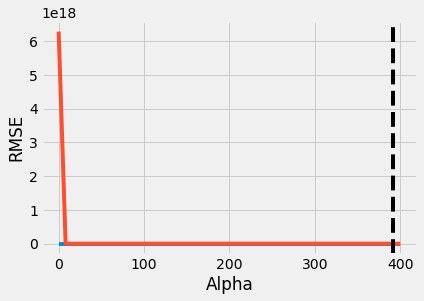

In [21]:
tr_rmse_ridge = []
tt_rmse_ridge = []
alphas_ridge = []

for alpha in np.linspace(0, 400, num=50):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr2_sc, y_tr2)
    tr_pred = ridge.predict(X_tr2_sc)
    tr_rmse_ridge.append(np.sqrt(mean_squared_error(y_tr2, tr_pred)))
    tt_pred = ridge.predict(X_tt2_sc)
    tt_rmse_ridge.append(np.sqrt(mean_squared_error(y_tt2, tt_pred)))
    alphas_ridge.append(alpha)

fig, ax = plt.subplots()
ax.plot(alphas_ridge, tr_rmse_ridge, label="Train")
ax.plot(alphas_ridge, tt_rmse_ridge, label="Test")
ax.set_xlabel("Alpha")
ax.set_ylabel("RMSE")
optimal_alpha = alphas_ridge[np.argmin(tt_rmse_ridge)]
ax.axvline(optimal_alpha, color="black", linestyle="--")
print(f'Optimal Alpha Value: {int(optimal_alpha)}')
plt.savefig('images/optimal_ridge.png')

# Optimal Alpha Value: 391

<img src="images/optimal_ridge.png">

In [22]:
ridge = Ridge(alpha=391, normalize=False)
ridge.fit(X_tr2_sc, y_tr2)
y_best_ridge_tr = ridge.predict(X_tr2_sc)
y_best_ridge_tt = ridge.predict(X_tt2_sc)

train_test_metrics(y_tr2, y_tt2, y_best_ridge_tr, y_best_ridge_tt)
print("")
rdgb_mse, rdgb_bias, rdgb_var = bias_variance_decomp(model, X_tr2_sc.values, y_tr2.values, X_tt2_sc.values, y_tt2.values, loss='mse', random_seed=42)    
print('Average expected loss: ', "{:.4e}".format(rdgb_mse))
print('Average bias: ', "{:.4e}".format(rdgb_bias))
print('Average variance: ', "{:.4e}".format(rdgb_var))


Training R^2 Score:  0.8587
Training MAE:  84903
Training MSE:  1.9905e+10
Training RMSE:  141083
Training Bias:  0.0
Training Variance:  1.1803e+11

Testing R^2 Score:  0.8478
Testing MAE:  84424
Testing MSE:  2.0248e+10
Testing RMSE:  142296
Testing Bias:  9477.89
Testing Variance:  1.1605e+11

Average expected loss:  1.0514e+35
Average bias:  1.1354e+33
Average variance:  1.0401e+35


In [23]:
top_feat_ridge = pd.DataFrame(np.abs(ridge.coef_), index=np.array(X_tr2_sc.columns), columns=['importance']).sort_values('importance', ascending=False)
top_feat_ridge.head(20)

,importance
zip_98004,70828.327238
sqft_living waterfront,68649.541461
zip_98039,50283.847517
zip_98112,48713.201931
grd_11,46598.172716
sqft_living^2,46251.790675
sqft_living,45261.686548
grd_10,42766.071827
grd_12,39533.385732
sqft_living age,38363.803677


In [24]:
top_feat_ridge.tail(20)

,importance
zip_98077,918.701522
zip_98019,883.466010
zip_98108,859.384422
bth_0.75,836.315150
bth_2.25,607.925230
zip_98065,544.369445
zip_98070,514.810798
zip_98106,409.487747
bth_0.5,401.640598
zip_98014,356.789094


## Lasso Regression

In [25]:
lasso = Lasso(alpha=1).fit(X_tr2_sc, y_tr2)
y_lasso_tr = lasso.predict(X_tr2_sc)
y_lasso_tt = lasso.predict(X_tt2_sc)

train_test_metrics(y_tr2, y_tt2, y_lasso_tr, y_lasso_tt)
print("")
lss_mse, lss_bias, lss_var = bias_variance_decomp(model, X_tr2_sc.values, y_tr2.values, X_tt2_sc.values, y_tt2.values, loss='mse', random_seed=42)    
print('Average expected loss: ', "{:.4e}".format(lss_mse))
print('Average bias: ', "{:.4e}".format(lss_bias))
print('Average variance: ', "{:.4e}".format(lss_var))

Training R^2 Score:  0.863
Training MAE:  84308
Training MSE:  1.9304e+10
Training RMSE:  138937
Training Bias:  0.0
Training Variance:  1.2159e+11

Testing R^2 Score:  0.8432
Testing MAE:  85244
Testing MSE:  2.0857e+10
Testing RMSE:  144420
Testing Bias:  9477.89
Testing Variance:  1.1950e+11

Average expected loss:  1.0514e+35
Average bias:  1.1354e+33
Average variance:  1.0401e+35


Optimal Alpha Value: 857


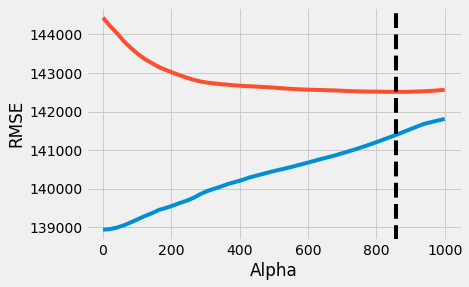

In [27]:
tr_rmse_lasso = []
tt_rmse_lasso = []
alphas_lasso = []

for alpha in np.linspace(0, 1000, num=50):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_tr2_sc, y_tr2)
    tr_pred = lasso.predict(X_tr2_sc)
    tr_rmse_lasso.append(np.sqrt(mean_squared_error(y_tr2, tr_pred)))
    tt_pred = lasso.predict(X_tt2_sc)
    tt_rmse_lasso.append(np.sqrt(mean_squared_error(y_tt2, tt_pred)))
    alphas_lasso.append(alpha)

fig, ax = plt.subplots()
ax.plot(alphas_lasso, tr_rmse_lasso, label="Train")
ax.plot(alphas_lasso, tt_rmse_lasso, label="Test")
ax.set_xlabel("Alpha")
ax.set_ylabel("RMSE")
optimal_alpha = alphas_lasso[np.argmin(tt_rmse_lasso)]
ax.axvline(optimal_alpha, color="black", linestyle="--")
print(f'Optimal Alpha Value: {int(optimal_alpha)}')
plt.savefig('images/optimal_lasso.png')

# Optimal Alpha Value: 857

<img src="images/optimal_lasso.png">

In [28]:
best_lasso = Lasso(alpha=857, normalize=False).fit(X_tr2_sc, y_tr2)
y_best_lasso_tr = best_lasso.predict(X_tr2_sc)
y_best_lasso_tt = best_lasso.predict(X_tt2_sc)

train_test_metrics(y_tr2, y_tt2, y_best_lasso_tr, y_best_lasso_tt)
print("")
lssb_mse, lssb_bias, lssb_var = bias_variance_decomp(model, X_tr2_sc.values, y_tr2.values, X_tt2_sc.values, y_tt2.values, loss='mse', random_seed=42)    
print('Average expected loss: ', "{:.4e}".format(lssb_mse))
print('Average bias: ', "{:.4e}".format(lssb_bias))
print('Average variance: ', "{:.4e}".format(lssb_var))

Training R^2 Score:  0.8581
Training MAE:  85350
Training MSE:  1.9992e+10
Training RMSE:  141393
Training Bias:  0.0
Training Variance:  1.1785e+11

Testing R^2 Score:  0.8474
Testing MAE:  84932
Testing MSE:  2.0309e+10
Testing RMSE:  142508
Testing Bias:  9477.89
Testing Variance:  1.1707e+11

Average expected loss:  1.0514e+35
Average bias:  1.1354e+33
Average variance:  1.0401e+35


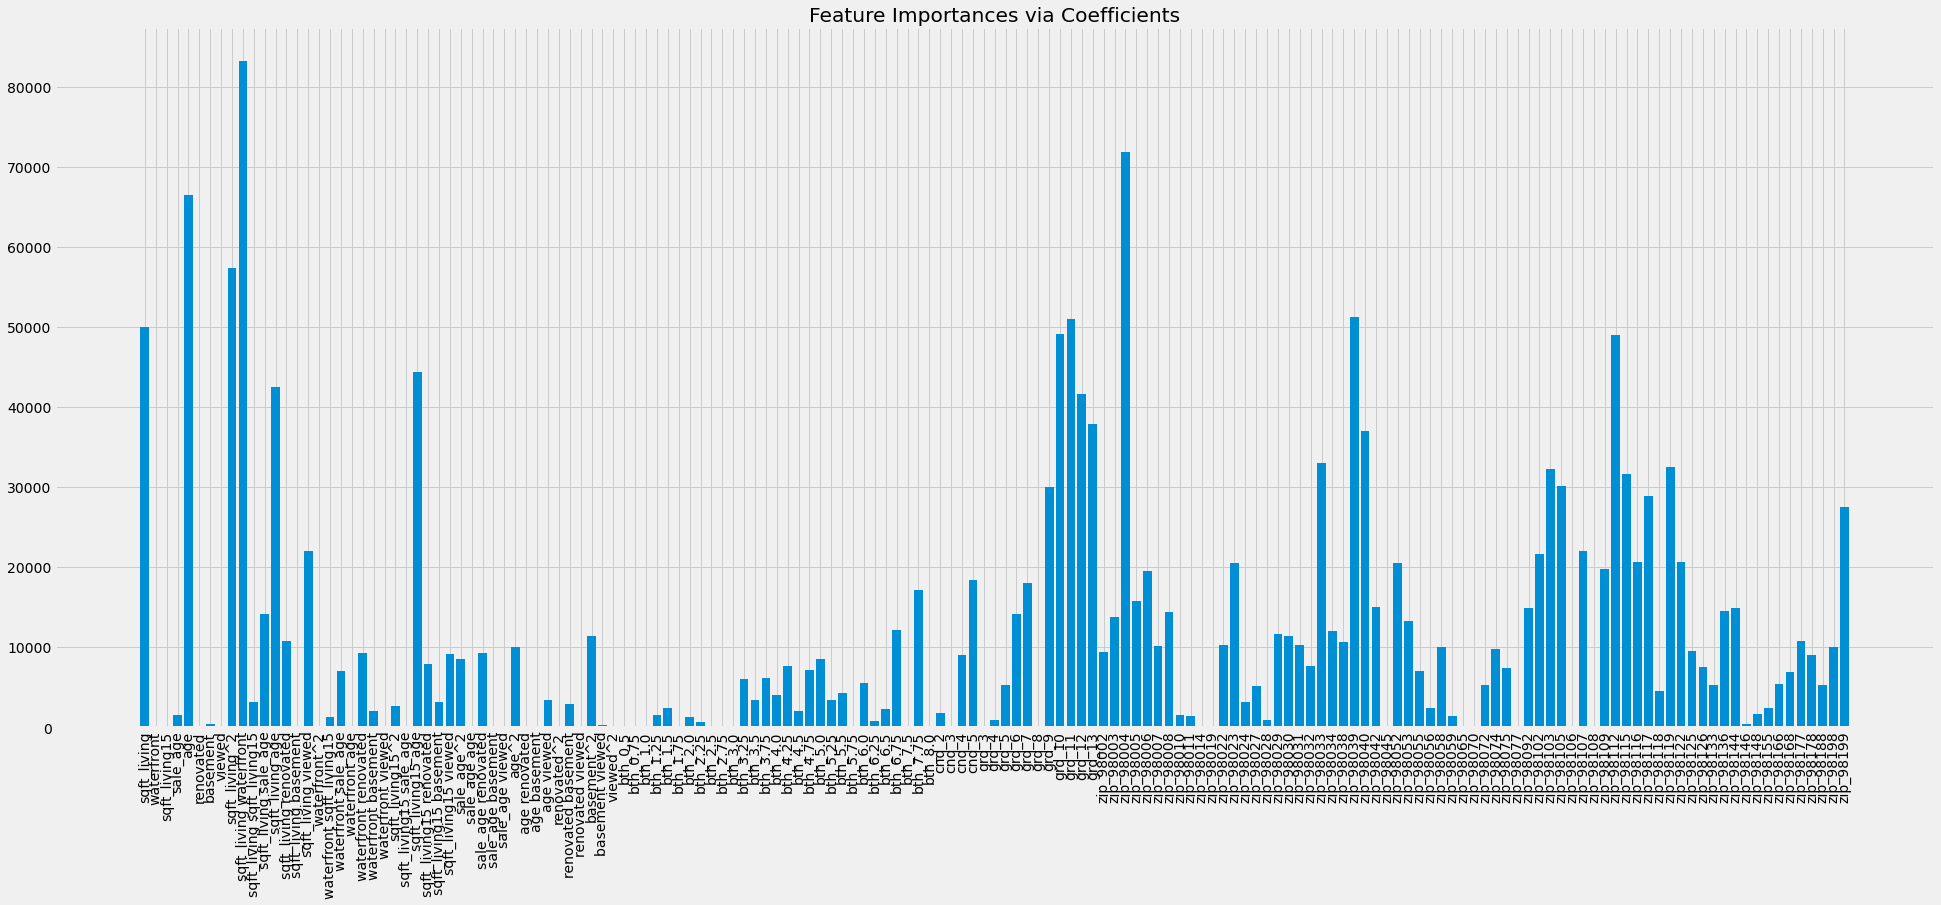

In [29]:
importance = np.abs(best_lasso.coef_)
names = np.array(X_tr2_sc.columns)
fig, ax = plt.subplots(figsize=(30, 12))
plt.bar(height=importance, x=names)
plt.xticks(rotation = 90)
plt.title("Feature Importances via Coefficients")
plt.show()


In [30]:
top_feat_lasso = pd.DataFrame(np.abs(best_lasso.coef_),
                              index=np.array(X_tr2_sc.columns),
                              columns=['importance']).sort_values('importance', ascending=False)
top_feat_lasso.head(20)

,importance
sqft_living waterfront,83233.800097
zip_98004,71822.370745
age,66466.034012
sqft_living^2,57350.791426
zip_98039,51253.316016
grd_11,50911.500044
sqft_living,49971.591416
grd_10,49131.142935
zip_98112,48944.218152
sqft_living15 age,44327.834348


In [31]:
lasso_zero = top_feat_lasso.loc[top_feat_lasso.importance == 0]
lasso_zero.index

Index(['sqft_living15', 'bth_1.0', 'bth_0.5', 'viewed^2', 'renovated viewed',
       'bth_2.75', 'renovated^2', 'age basement', 'age renovated',
       'sale_age viewed', 'sale_age basement', 'sale_age age',
       'sqft_living15 sale_age', 'bth_2.5', 'sqft_living basement',
       'renovated', 'cnd_3', 'zip_98019', 'zip_98014', 'waterfront^2',
       'waterfront age', 'grd_8', 'waterfront', 'grd_3', 'zip_98077',
       'zip_98045', 'bth_8.0', 'bth_7.5', 'viewed', 'zip_98106', 'bth_5.75',
       'zip_98108', 'bth_3.0', 'waterfront viewed'],
      dtype='object')

## Lasso Regression with AIC and BIC

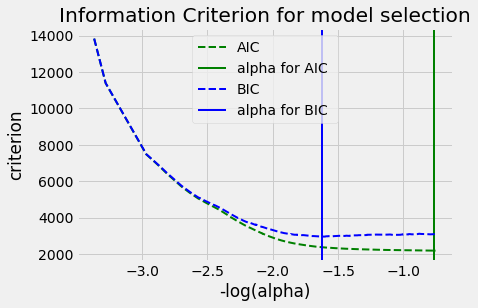

In [32]:
model_bic = LassoLarsIC(criterion="bic")
model_bic.fit(X_tr2_sc, y_tr2)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion="aic")
model_aic.fit(X_tr2_sc, y_tr2)
alpha_aic_ = model_aic.alpha_

def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color, linewidth=2, label=name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=2, label='alpha for %s ' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'green')
plot_ic_criterion(model_bic, 'BIC', 'blue')
plt.legend()
plt.title("Information Criterion for model selection");

In [33]:
aic_lasso = Lasso(alpha=model_aic.alpha_).fit(X_tr2_sc, y_tr2)
aic_tr_pred = aic_lasso.predict(X_tr2_sc)
aic_tt_pred = aic_lasso.predict(X_tt2_sc)

train_test_metrics(y_tr2, y_tt2, aic_tr_pred, aic_tt_pred)
print("")
aic_mse, aic_bias, aic_var = bias_variance_decomp(model, X_tr2_sc.values, y_tr2.values, X_tt2_sc.values, y_tt2.values, loss = 'mse', random_seed = 42)    
print('Average expected loss: ', "{:.4e}".format(aic_mse))
print('Average bias: ', "{:.4e}".format(aic_bias))
print('Average variance: ', "{:.4e}".format(aic_var))

Training R^2 Score:  0.863
Training MAE:  84297
Training MSE:  1.9304e+10
Training RMSE:  138938
Training Bias:  0.0
Training Variance:  1.2156e+11

Testing R^2 Score:  0.8434
Testing MAE:  85211
Testing MSE:  2.0841e+10
Testing RMSE:  144362
Testing Bias:  9477.89
Testing Variance:  1.1946e+11

Average expected loss:  1.0514e+35
Average bias:  1.1354e+33
Average variance:  1.0401e+35


In [34]:
top_feat_aic = pd.DataFrame(np.abs(aic_lasso.coef_),
                            index = np.array(X_tr2_sc.columns),
                            columns = ['importance']).sort_values('importance', ascending = False)
top_feat_aic.head(20)

,importance
sqft_living age,237418.331989
sqft_living sale_age,203971.277577
age renovated,111589.019719
waterfront^2,91128.721222
sqft_living waterfront,89143.485841
zip_98004,84971.092709
waterfront,81302.207138
sqft_living,80616.206841
sale_age,79093.398626
sqft_living renovated,71252.412835


In [35]:
bic_lasso = Lasso(alpha=model_bic.alpha_).fit(X_tr2_sc, y_tr2)
bic_tr_pred = bic_lasso.predict(X_tr2_sc)
bic_tt_pred = bic_lasso.predict(X_tt2_sc)

train_test_metrics(y_tr2, y_tt2, bic_tr_pred, bic_tt_pred)
print("")
bic_mse, bic_bias, bic_var = bias_variance_decomp(model, X_tr2_sc.values, y_tr2.values, X_tt2_sc.values, y_tt2.values, loss='mse', random_seed=42)    
print('Average expected loss: ', "{:.4e}".format(bic_mse))
print('Average bias: ', "{:.4e}".format(bic_bias))
print('Average variance: ', "{:.4e}".format(bic_var))

Training R^2 Score:  0.8629
Training MAE:  84240
Training MSE:  1.9320e+10
Training RMSE:  138995
Training Bias:  0.0
Training Variance:  1.2134e+11

Testing R^2 Score:  0.8441
Testing MAE:  84999
Testing MSE:  2.0743e+10
Testing RMSE:  144022
Testing Bias:  9477.89
Testing Variance:  1.1941e+11

Average expected loss:  1.0514e+35
Average bias:  1.1354e+33
Average variance:  1.0401e+35


In [36]:
top_feat_bic = pd.DataFrame(np.abs(bic_lasso.coef_),
                            index = np.array(X_tr2_sc.columns),
                            columns = ['importance']).sort_values('importance', ascending=False)
top_feat_bic.head(20)

,importance
sqft_living age,211000.374635
sqft_living sale_age,178380.958748
sqft_living waterfront,89162.347015
age renovated,87615.195255
zip_98004,83564.667358
sqft_living,75365.774543
zip_98112,60318.788484
sqft_living renovated,58308.201529
zip_98039,57177.918625
sale_age,57010.877375


## Decision Tree Regressor with GridSearchCV and Pipeline

In [37]:
dtr = DecisionTreeRegressor(random_state=42).fit(X_tr2, y_tr2)
y_tr_pred3 = dtr.predict(X_tr2) 
y_tt_pred3 = dtr.predict(X_tt2)

train_test_metrics(y_tr2, y_tt2, y_tr_pred3, y_tt_pred3)
print("")
dtr_mse, dtr_bias, dtr_var = bias_variance_decomp(model, X_tr2_sc.values, y_tr2.values, X_tt2_sc.values, y_tt2.values, loss='mse', random_seed=42)    
print('Average expected loss: ', "{:.4e}".format(dtr_mse))
print('Average bias: ', "{:.4e}".format(dtr_bias))
print('Average variance: ', "{:.4e}".format(dtr_var))

Training R^2 Score:  0.9999
Training MAE:  295
Training MSE:  1.7111e+07
Training RMSE:  4136
Training Bias:  -0.0
Training Variance:  1.4090e+11

Testing R^2 Score:  0.6855
Testing MAE:  119947
Testing MSE:  4.1847e+10
Testing RMSE:  204565
Testing Bias:  -1349.82
Testing Variance:  1.3112e+11

Average expected loss:  1.0514e+35
Average bias:  1.1354e+33
Average variance:  1.0401e+35


In [44]:
rmse_scorer = make_scorer('root_mean_squared_error', 
                           mean_squared_error,
                           greater_is_better=False, 
                           squared=False)
pipe_tree = make_pipeline(tree.DecisionTreeRegressor(random_state=1))
dtm = DecisionTreeRegressor()
param_grid = [{
               'decisiontreeregressor__max_depth': [1, 2, 5, 10, 15, 20],
               'decisiontreeregressor__min_samples_leaf': [1, 5, 10, 20, 50],
               'decisiontreeregressor__max_leaf_nodes': [5, 10, 20, 50, 100],
               'decisiontreeregressor__min_samples_split': [5, 10, 20, 40]
             }]
gs = GridSearchCV(pipe_tree, param_grid=param_grid, cv=10, scoring=rmse_scorer, verbose=1)
gs.fit(X_tr2, y_tr2)
print(f"Training Score: {gs.best_score_}")
print(gs.best_estimator_)

# Fitting 10 folds for each of 600 candidates, totalling 6000 fits
# Training Score: -175078.03997151004
# Pipeline(steps=[('decisiontreeregressor',
#                  DecisionTreeRegressor(max_depth=10, max_leaf_nodes=100,
#                                        min_samples_split=40, random_state=1))])

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Training Score: nan
Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=1, max_leaf_nodes=5,
                                       min_samples_split=5, random_state=1))])


In [37]:
gs_model = gs.best_estimator_
gs_model.fit(X_tr2, y_tr2)
gs_tr_pred = gs_model.predict(X_tr2)
gs_tt_pred = gs_model.predict(X_tt2) 

train_test_metrics(y_tr2, y_tt2, y_tr_pred3, y_tt_pred3)
print("")
dtr_mse, dtr_bias, dtr_var = bias_variance_decomp(model, X_tr2_sc.values, y_tr2.values, X_tt2_sc.values, y_tt2.values, loss='mse', random_seed=42)    
print('Average expected loss: ', "{:.4e}".format(dtr_mse))
print('Average bias: ', "{:.4e}".format(dtr_bias))
print('Average variance: ', "{:.4e}".format(dtr_var))




# print('Training R^2 Score: ', round(r2_score(y_tr2, gs_tr_pred), 4))
# print('Training MAE: ', round(mean_absolute_error(y_tr2, gs_tr_pred), 2))
# print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, gs_tr_pred)))
# print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, gs_tr_pred)), 2))
# print('Training Bias: ', round(bias(y_tr2, gs_tr_pred), 2))
# print('Training Variance: ', "{:.4e}".format(variance(gs_tr_pred)))
# print("")
# print('Testing R^2 Score: ', round(r2_score(y_tt2, gs_tt_pred), 4))
# print('Testing MAE: ', round(mean_absolute_error(y_tt2, gs_tt_pred), 2))
# print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, gs_tt_pred)))
# print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, gs_tt_pred)), 2))
# print('Testing Bias: ', round(bias(y_tt2, gs_tt_pred), 2))
# print('Testing Variance: ', "{:.4e}".format(variance(gs_tt_pred)))

# Training R^2 Score:  0.8579
# Training MAE:  88207.83
# Training MSE:  2.0018e+10
# Training RMSE:  141486.22
# Training Bias:  0.0
# Training Variance:  1.2090e+11

# Testing R^2 Score:  0.7933
# Testing MAE:  95884.01
# Testing MSE:  2.7501e+10
# Testing RMSE:  165834.58
# Testing Bias:  -1342.05
# Testing Variance:  1.0614e+11

dtr = DecisionTreeRegressor(random_state=42).fit(X_tr2, y_tr2)
y_tr_pred3 = dtr.predict(X_tr2) 
y_tt_pred3 = dtr.predict(X_tt2)

train_test_metrics(y_tr2, y_tt2, y_tr_pred3, y_tt_pred3)
print("")
dtr_mse, dtr_bias, dtr_var = bias_variance_decomp(model, X_tr2_sc.values, y_tr2.values, X_tt2_sc.values, y_tt2.values, loss='mse', random_seed=42)    
print('Average expected loss: ', "{:.4e}".format(dtr_mse))
print('Average bias: ', "{:.4e}".format(dtr_bias))
print('Average variance: ', "{:.4e}".format(dtr_var))

Training R^2 Score:  0.8579
Training MAE:  88207.83
Training MSE:  2.0018e+10
Training RMSE:  141486.22
Training Bias:  0.0
Training Variance:  1.2090e+11

Testing R^2 Score:  0.7933
Testing MAE:  95884.01
Testing MSE:  2.7501e+10
Testing RMSE:  165834.58
Testing Bias:  -1342.05
Testing Variance:  1.0614e+11


In [38]:
dtr = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=100,
                            min_samples_leaf=5,
                            min_samples_split=40,
                            random_state=1).fit(X_tr2, y_tr2)

In [74]:
top_feat_dt = pd.DataFrame(dtr.feature_importances_,
                           index=X_tr2.columns,
                           columns=['importance']).sort_values('importance', ascending=False)
top_feat_dt.head(20)

,importance
sqft_living lat,0.475641
lat^2,0.160390
sqft_living sqft_living15,0.117406
sqft_living basement,0.051939
long,0.031739
lat,0.025609
long^2,0.023008
sqft_living15 age,0.013337
sqft_above sqft_living15,0.013225
sqft_above sqft_lot15,0.010962


In [98]:
dt_zero = top_feat_dt.loc[top_feat_dt.importance == 0]
dt_zero.index.tolist()

['bth_6.5',
 'zip_98014',
 'zip_98032',
 'bth_6.0',
 'zip_98031',
 'bth_7.5',
 'bth_6.75',
 'zip_98029',
 'zip_98028',
 'zip_98022',
 'zip_98023',
 'zip_98024',
 'zip_98027',
 'zip_98030',
 'bth_6.25',
 'zip_98019',
 'bth_8.0',
 'zip_98011',
 'zip_98010',
 'grd_9',
 'grd_5',
 'grd_4',
 'grd_3',
 'zip_98033',
 'cnd_5',
 'cnd_4',
 'grd_13',
 'cnd_3',
 'zip_98002',
 'zip_98003',
 'cnd_2',
 'zip_98005',
 'zip_98006',
 'zip_98007',
 'zip_98008',
 'bth_7.75',
 'sqft_living',
 'zip_98059',
 'zip_98034',
 'zip_98136',
 'zip_98115',
 'zip_98116',
 'zip_98117',
 'zip_98118',
 'zip_98119',
 'zip_98122',
 'zip_98125',
 'zip_98126',
 'zip_98133',
 'zip_98144',
 'zip_98108',
 'zip_98146',
 'zip_98148',
 'zip_98155',
 'zip_98166',
 'zip_98168',
 'zip_98177',
 'zip_98178',
 'zip_98188',
 'zip_98198',
 'zip_98109',
 'zip_98107',
 'zip_98038',
 'bth_5.5',
 'zip_98039',
 'zip_98040',
 'zip_98042',
 'zip_98045',
 'zip_98052',
 'zip_98053',
 'zip_98055',
 'zip_98056',
 'zip_98058',
 'zip_98065',
 'zip_9810

## Random Forest Regressor with RandomSearchCV and GridSearchCV

In [76]:
rf = RandomForestRegressor(n_estimators=100, 
                           max_features="auto", 
                           max_depth=100, 
                           min_samples_leaf=4, 
                           min_samples_split=10, 
                           random_state=1).fit(X_tr2, y_tr2)
rf_tr_pred = rf.predict(X_tr2)
rf_tt_pred = rf.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, rf_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, rf_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, rf_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, rf_tr_pred)), 2))
print('Training Bias: ', bias(y_tr2, rf_tr_pred))
print('Training Variance: ', "{:.4e}".format(variance(rf_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, rf_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, rf_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, rf_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, rf_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt2, rf_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(rf_tt_pred)))

Training R^2 Score:  0.9458
Training MAE:  42564.3
Training MSE:  7.6441e+09
Training RMSE:  87430.82
Training Bias:  190.05
Training Variance:  1.1999e+11

Testing R^2 Score:  0.8705
Testing MAE:  71651.21
Testing MSE:  1.7237e+10
Testing RMSE:  131289.66
Testing Bias:  -1104.78
Testing Variance:  1.0170e+11


In [77]:
top_feat_rf = pd.DataFrame(rf.feature_importances_,
                           index=X_tr2.columns,
                           columns=['importance']).sort_values('importance', ascending=False)
top_feat_rf.head(20)

,importance
sqft_living lat,0.307188
sqft_living sqft_living15,0.155893
lat^2,0.075278
lat,0.070771
sqft_living long,0.049169
lat long,0.028410
long^2,0.022321
long,0.021555
sqft_living basement,0.021085
sqft_living viewed,0.020610


In [99]:
top_feat_rf.value_counts()

importance
0.000000      17
0.000032       1
0.000050       1
0.000050       1
0.000050       1
              ..
0.000738       1
0.000688       1
0.000687       1
0.000684       1
0.000217       1
Length: 201, dtype: int64

In [55]:
random_grid = {'n_estimators': [20, 50, 100, 150, 200],
               'max_depth': [10, 20, 50, 100],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_tr2, y_tr2)
rf_random.best_params_


# Fitting 3 folds for each of 100 candidates, totalling 300 fits
# {'n_estimators': 150,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_depth': 50}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 50}

In [62]:
best_random = rf_random.best_estimator_
rf_random_tr = rf_random.predict(X_tr2)
rf_random_tt = rf_random.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, rf_random_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, rf_random_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, rf_random_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, rf_random_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, rf_random_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(rf_random_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, rf_random_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, rf_random_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, rf_random_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, rf_random_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, rf_random_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(rf_random_tt)))

Training R^2 Score:  0.9801
Training MAE:  27058.29
Training MSE:  2.8010e+09
Training RMSE:  52924.47
Training Bias:  -14.82
Training Variance:  1.2696e+11

Testing R^2 Score:  0.8778
Testing MAE:  70402.12
Testing MSE:  1.6264e+10
Testing RMSE:  127528.55
Testing Bias:  -1052.86
Testing Variance:  1.0265e+11


In [63]:
top_feat_rf_rcv = pd.DataFrame(best_random.feature_importances_,
                           index=X_tr2.columns,
                           columns=['importance']).sort_values('importance', ascending=False)
top_feat_rf_rcv.head(20)

,importance
sqft_living lat,0.297823
sqft_living sqft_living15,0.131081
lat^2,0.072726
lat,0.069335
sqft_living long,0.061776
lat long,0.029113
long^2,0.022179
long,0.021591
sqft_above sqft_living15,0.019045
sqft_living viewed,0.017634


In [100]:
top_feat_rf_rcv.value_counts()

importance
0.000000      3
0.000104      1
0.000098      1
0.000095      1
0.000090      1
             ..
0.000995      1
0.000993      1
0.000988      1
0.000953      1
0.000298      1
Length: 215, dtype: int64

In [47]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_tr2, y_tr2)
grid_search.best_params_

# Fitting 3 folds for each of 288 candidates, totalling 864 fits
# {'bootstrap': True,
#  'max_depth': 110,
#  'max_features': 3,
#  'min_samples_leaf': 3,
#  'min_samples_split': 8,
#  'n_estimators': 200}


Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [ ]:
best_grid = grid_search.best_estimator_
rf_gs_tr = best_grid.predict(X_tr2)
rf_gs_tt = best_grid.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, rf_gs_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, rf_gs_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, rf_gs_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, rf_gs_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, rf_gs_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(rf_gs_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, rf_gs_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, rf_gs_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, rf_gs_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, rf_gs_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, rf_gs_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(rf_gs_tt)))

# Training R^2 Score:  0.8427
# Training MAE:  83705.74
# Training MSE:  2.2172e+10
# Training RMSE:  148904.28
# Training Bias:  -239.46
# Training Variance:  8.0044e+10

# Testing R^2 Score:  0.7613
# Testing MAE:  98035.45
# Testing MSE:  3.1765e+10
# Testing RMSE:  178228.29
# Testing Bias:  -1378.33
# Testing Variance:  6.5898e+10

In [101]:
top_feat_rf_gs = pd.DataFrame(best_grid.feature_importances_,
                              index=X_tr2.columns,
                              columns=['importance']).sort_values('importance', ascending=False)
top_feat_rf_gs.head(20)

,importance
sqft_living15^2,0.038026
sqft_living sqft_above,0.032620
sqft_living sqft_living15,0.029391
sqft_living lat,0.027265
sqft_living long,0.026596
lat^2,0.026509
sqft_above lat,0.023884
lat,0.023300
sqft_above sqft_living15,0.023174
long sqft_living15,0.022903


In [102]:
top_feat_rf_gs.value_counts()

importance
0.000000      10
0.032620       1
0.000379       1
0.000366       1
0.000335       1
              ..
0.004418       1
0.004411       1
0.004376       1
0.004358       1
0.001655       1
Length: 208, dtype: int64

# Results

In [67]:
list_rmse = [[rmse(y_tr, y_tr_pred), rmse(y_tt, y_tt_pred)],
             [rmse(y_tr, y_kb_tr_pred), rmse(y_tt, y_kb_tt_pred)],
             [rmse(y_tr, y_tr_pred_rfe), rmse(y_tt, y_tt_pred_rfe)],
             [rmse(y_tr2, y_tr_pred2), rmse(y_tt2, y_tt_pred2)],
             [rmse(y_tr2, y_ridge_tr), rmse(y_tt2, y_ridge_tt)],
             [rmse(y_tr2, y_best_ridge_tr), rmse(y_tt2, y_best_ridge_tt)],
             [rmse(y_tr2, y_lasso_tr), rmse(y_tt2, y_lasso_tt)],
             [rmse(y_tr2, y_best_lasso_tr), rmse(y_tt2, y_best_lasso_tt)],
             [rmse(y_tr2, aic_tr_pred), rmse(y_tt2, aic_tt_pred)],
             [rmse(y_tr2, bic_tr_pred), rmse(y_tt2, bic_tt_pred)],
             [rmse(y_tr2, y_tr_pred3), rmse(y_tt2, y_tt_pred3)],
             [rmse(y_tr2, gs_tr_pred), rmse(y_tt2, gs_tt_pred)],
             [rmse(y_tr2, rf_tr_pred), rmse(y_tt2, rf_tt_pred)],
             [rmse(y_tr2, rf_random_tr), rmse(y_tt2, rf_random_tt)],
             [rmse(y_tr2, rf_gs_tr), rmse(y_tt2, rf_gs_tt)]]

In [69]:
index = ["Baseline 1", "K-Best", "RFECV", "Baseline 2", "Ridge", "Best Ridge", "Lasso", "Best Lasso", "Lasso AIC", "Lasso BIC", "Decision Tree", "DT GridSearchCV", "Random Forest", "RF RandomSearchCV", "RF GridSearchCV"]
columns = ["Training RMSE", "Testing RMSE"]
rmse_df = pd.DataFrame(data=list_rmse, index=index, columns=columns)

In [70]:
rmse_df

,Training RMSE,Testing RMSE
Baseline 1,128094.52,134097.92
K-Best,209795.48,202748.99
RFECV,127719.34,133569.89
Baseline 2,131279.78,135544.37
Ridge,134418.16,142728.44
Best Ridge,132583.55,141224.64
Lasso,135006.92,142731.09
Best Lasso,136264.04,140134.98
Lasso AIC,135009.20,142691.23
Lasso BIC,135157.01,141539.03


In [79]:
top_feat_dt

,importance
sqft_living lat,0.475641
lat^2,0.160390
sqft_living sqft_living15,0.117406
sqft_living basement,0.051939
long,0.031739
...,...
age^2,0.000000
age renovated,0.000000
age basement,0.000000
age viewed,0.000000


In [106]:
top_feat_ridge.index[0]

'sqft_living lat'

In [107]:
list_top3 = [[top_feat_ridge.index[0], top_feat_ridge.index[1], top_feat_ridge.index[2]],
             [top_feat_lasso.index[0], top_feat_lasso.index[1], top_feat_lasso.index[2]],
             [top_feat_dt.index[0], top_feat_dt.index[1], top_feat_dt.index[2]],
             [top_feat_rf.index[0], top_feat_rf.index[1], top_feat_rf.index[2]],
             [top_feat_rf_rcv.index[0], top_feat_rf_rcv.index[1], top_feat_rf_rcv.index[2]],
             [top_feat_rf_gs.index[0], top_feat_rf_gs.index[1], top_feat_rf_gs.index[2]]]
index = ["Ridge", "Lasso", "Decision Tree", "Random Forest", "RF RandomSearch", "RF GridSearch"]
columns = ["First", "Second", "Third". "Fourth", "Fifth"]
top3_df = pd.DataFrame(data=list_top3, index=index, columns=columns)                  

In [108]:
top3_df

,First,Second,Third
Ridge,sqft_living lat,sqft_living,sqft_above
Lasso,sqft_living waterfront,age,sqft_living age
Decision Tree,sqft_living lat,lat^2,sqft_living sqft_living15
Random Forest,sqft_living lat,sqft_living sqft_living15,lat^2
RF RandomSearch,sqft_living lat,sqft_living sqft_living15,lat^2
RF GridSearch,sqft_living15^2,sqft_living sqft_above,sqft_living sqft_living15


In [ ]:
#instantiate a linear regression object
rf_final = RandomForestRegressor(n_estimators=100, 
                           max_features="auto", 
                           max_depth=100, 
                           min_samples_leaf=4, 
                           min_samples_split=10, 
                           random_state=1).fit(X_tr2, y_tr2)
rf_final.fit(X_tr2, y_tr2)

In [ ]:
lm_final.coef_

## Gradient Boosting Regression Trees (GBRT)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor 

In [ ]:
gbrt = GradientBoostingRegressor(n_estimators=100).fit(X_tr2, y_tr2) 
y_pred_gbrt_tr = gbrt.predict(X_tr2)
y_pred_gbrt_tt = gbrt.predict(X_tt2)

print("Feature Importances: ", gbrt.feature_importances_)



# Pickle

In [ ]:
pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("scaler.pickle", "wb")
pickle.dump(scaler, pickle_out)
pickle_out.close